In [ ]:
import random as rd

Variant = 21
rd.seed(Variant)

Numbers_of_problems = [i+1 for i in rd.sample(range(11),2)]
Numbers_of_problems
#3, 7

In [ ]:
format ELF64
public _start

include '/home/egorp/cpp/System-programming/help.asm'

section '.bss' writable
    input_fd     dq 0
    output_fd    dq 0
    bytes_read   dq 0
    line_count   dq 0

section '.data' writable
    newline      db 0x0A
    BUFFER_SIZE equ 65536
    buffer       rb BUFFER_SIZE
    line_ptrs    rq 10000

section '.text' executable
_start:
    mov rax, [rsp]
    cmp rax, 3
    jge .open_input
    jmp .exit

.open_input:
    mov rax, 2
    mov rdi, [rsp + 16]
    mov rsi, 0
    mov rdx, 0
    syscall
    cmp rax, 0
    jl .exit
    mov [input_fd], rax

    mov rax, 0
    mov rdi, [input_fd]
    mov rsi, buffer
    mov rdx, BUFFER_SIZE
    syscall
    cmp rax, 0
    jle .close_input
    mov [bytes_read], rax

.close_input:
    mov rax, 3
    mov rdi, [input_fd]
    syscall

    cmp qword [bytes_read], 0
    je .exit

    mov rax, 2
    mov rdi, [rsp + 24]
    mov rsi, 101o
    mov rdx, 644o
    syscall
    cmp rax, 0
    jl .exit
    mov [output_fd], rax

.parse_lines:
    mov rsi, buffer
    mov rdi, line_ptrs
    mov rbx, [bytes_read]
    mov qword [line_count], 1

    mov [rdi], rsi
    add rdi, 8

.parse_loop:
    test rbx, rbx
    jz .parse_done

    cmp byte [rsi], 0x0A
    jne .next_byte

    mov byte [rsi], 0


    inc rsi
    dec rbx
    jz .parse_done

    mov [rdi], rsi
    inc qword [line_count]
    add rdi, 8
    jmp .parse_loop

.next_byte:
    inc rsi
    dec rbx
    jmp .parse_loop

.parse_done:
    mov rcx, [line_count]
    test rcx, rcx
    jz .close_output

    dec rcx

.write_loop:
    push rcx
    mov rax, rcx
    shl rax, 3
    mov rsi, [line_ptrs + rax]

    mov rdi, rsi
    call .strlen
    mov rdx, rax

    test rdx, rdx
    jz .write_newline

    mov rax, 1
    mov rdi, [output_fd]
    syscall

.write_newline:
    mov rax, 1
    mov rdi, [output_fd]
    mov rsi, newline
    mov rdx, 1
    syscall

    pop rcx
    dec rcx
    jns .write_loop

.close_output:
    mov rax, 3
    mov rdi, [output_fd]
    syscall

.exit:
    mov rax, 60
    xor rdi, rdi
    syscall

.strlen:
    xor rax, rax
.strlen_loop:
    cmp byte [rdi + rax], 0
    je .strlen_done
    inc rax
    jmp .strlen_loop
.strlen_done:
    ret


input.txt

line1
line2
line3
line4
line5


output.txt

line5
line4
line3
line2
line1

;;encrypt.asm

format ELF64
public _start

include '/home/egorp/cpp/System-programming/func.asm'

section '.bss' writable
    input_fd     dq 0
    output_fd    dq 0
    bytes_read   dq 0
    shift_value  dq 0

section '.data' writable
    BUFFER_SIZE equ 65536
    buffer       rb BUFFER_SIZE
    newline db 0x0A

section '.text' executable
_start:
    mov r8, [rsp + 16]
    mov r9, [rsp + 24]

    mov rsi, [rsp + 32]
    call atoi
    mov [shift_value], rax

    mov rax, 2
    mov rdi, r8
    mov rsi, 0
    mov rdx, 0
    syscall
    mov [input_fd], rax

    mov rax, 0
    mov rdi, [input_fd]
    mov rsi, buffer
    mov rdx, BUFFER_SIZE
    syscall
    cmp rax, 0
    jle .close_input
    mov [bytes_read], rax

.close_input:
    mov rax, 3
    mov rdi, [input_fd]
    syscall

    mov rsi, buffer
    mov rcx, [bytes_read]
    mov rdx, [shift_value]
    call .encrypt

.write_output:
    mov rax, 2
    mov rdi, r9
    mov rsi, 101o
    mov rdx, 644o
    syscall
    mov [output_fd], rax

    mov rax, 1
    mov rdi, [output_fd]
    mov rsi, buffer
    mov rdx, [bytes_read]
    syscall

    mov rax, 3
    mov rdi, [output_fd]
    syscall

    jmp exit

.encrypt:
    test rcx, rcx
    jz .encrypt_done

    mov rbx, [shift_value]   ; загружаем сдвиг в rbx
    mov bl, 3
    mov r8b, 26

.encrypt_loop:
    mov al, [rsi]

    ; (A-Z)
    cmp al, 'A'
    jb .next_char
    cmp al, 'Z'
    ja .check_lowercase

    sub al, 'A'
    add al, bl
    cmp al, r8b
    jl .process_shift_upper
    sub al, 26

.process_shift_upper:
    add al, 'A'
    jmp .store_char

.check_lowercase:
    ; (a-z)
    cmp al, 'a'
    jb .next_char
    cmp al, 'z'
    ja .next_char

    sub al, 'a'
    add al, bl
    cmp al, r8b
    jl .process_shift_lower
    sub al, 26

.process_shift_lower:
    add al, 'a'

.store_char:
    mov [rsi], al

.next_char:
    inc rsi
    dec rcx
    jnz .encrypt_loop

.encrypt_done:
    ret

exit:
    mov rax, 60
    xor rdi, rdi
    syscall


In [ ]:
;;decrypt.asm

format ELF64
public _start

include '/home/egorp/cpp/System-programming/func.asm'

section '.bss' writable
    input_fd     dq 0
    output_fd    dq 0
    bytes_read   dq 0
    shift_value  dq 0

section '.data' writable
    BUFFER_SIZE equ 65536
    buffer       rb BUFFER_SIZE

section '.text' executable
_start:
    mov r8, [rsp + 16]
    mov r9, [rsp + 24]

    mov rsi, [rsp + 32]
    call atoi
    mov [shift_value], rax

    mov rax, 2
    mov rdi, r8
    mov rsi, 0
    mov rdx, 0
    syscall
    mov [input_fd], rax

    mov rax, 0
    mov rdi, [input_fd]
    mov rsi, buffer
    mov rdx, BUFFER_SIZE
    syscall
    cmp rax, 0
    jle .close_input
    mov [bytes_read], rax

.close_input:
    mov rax, 3
    mov rdi, [input_fd]
    syscall

    mov rsi, buffer
    mov rcx, [bytes_read]
    mov rdx, [shift_value]
    call .decrypt

.write_output:
    mov rax, 2
    mov rdi, r9
    mov rsi, 101o
    mov rdx, 644o
    syscall
    mov [output_fd], rax

    mov rax, 1
    mov rdi, [output_fd]
    mov rsi, buffer
    mov rdx, [bytes_read]
    syscall

    mov rax, 3
    mov rdi, [output_fd]
    syscall

    jmp exit

.decrypt:
    test rcx, rcx
    jz .decrypt_done

.decrypt_loop:
    mov al, [rsi]

    ; (A-Z)
    cmp al, 'A'
    jb .next_char
    cmp al, 'Z'
    ja .check_lowercase

    sub al, 'A'
    mov rbx, [shift_value]
    cmp al, bl
    jge .process_shift_upper
    add al, 26

.process_shift_upper:
    sub al, bl
    add al, 'A'
    jmp .store_char

.check_lowercase:
    ; (a-z)
    cmp al, 'a'
    jb .next_char
    cmp al, 'z'
    ja .next_char

    sub al, 'a'
    mov rbx, [shift_value]
    cmp al, bl
    jge .process_shift_lower
    add al, 26

.process_shift_lower:
    sub al, bl
    add al, 'a'

.store_char:
    mov [rsi], al

.next_char:
    inc rsi
    dec rcx
    jnz .decrypt_loop

.decrypt_done:
    ret

exit:
    mov rax, 60
    xor rdi, rdi
    syscall


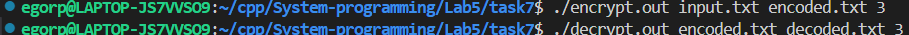

input.txt

Plain text abcdef

encoded.txt

Sodlq whaw defghi

decoded.txt

Plain text abcdef